In [1]:
import sys
sys.path.append('/Users/mahsazarei/Grantlab Brugada Dropbox/TerraMera/Gitlab/Mahsa/AA_APLID/Amino_Acid_manuscript/helper_functions')
from load_data import *
from utils import *
from models import *

# Step 1: Read AAF (spectra) and AA proportions (ground-truth)

In [2]:
data_dir_x = '/Users/mahsazarei/Grantlab Brugada Dropbox/TerraMera/Gitlab/Mahsa/AA_APLID/Amino_Acid_manuscript/Data/AAF_Data'
specs_ex, w_cm, w_nm, names_ex = data_loader_by_path(data_dir_x, skiprows=45)
specs_ex = specs_ex.T

In [3]:
data_dir_y = '/Users/mahsazarei/Grantlab Brugada Dropbox/TerraMera/Gitlab/Mahsa/AA_APLID/Amino_Acid_manuscript/Data/AA_GroundTruth/AAF_proportions.xlsx'
df_gt, y_ex, y_names, namess= y_loader_by_path(data_dir_y)
y_expanded = [y_ex[df_gt.index==name] for name in names_ex]
y_ex = np.vstack(y_expanded)
print(specs_ex.shape, names_ex.shape, y_ex.shape)

(2880, 1024) (2880,) (2880, 6)


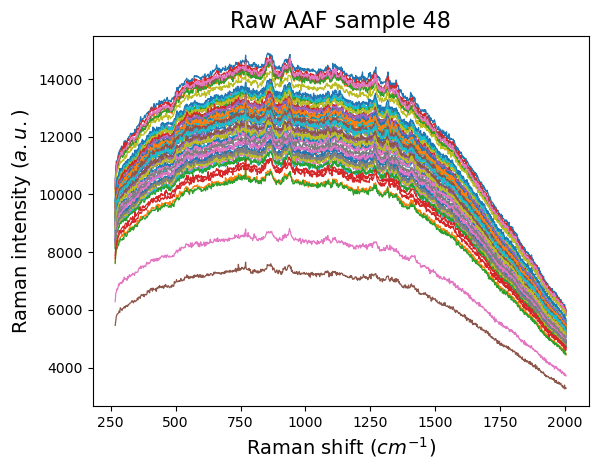

In [4]:
plot_specs(specs_ex[names_ex=='ab48'], w_cm,  title='Raw AAF sample 48', data='Raman')

# Step 2: Preprocessing Table of Contents
- [1. Background subtraction using Discrete Wavelet Transform (DWT) - one spectrum](#dwt_background)
- [1.1 Background subtraction using Discrete Wavelet Transform (DWT) - all spectra](#dwt_all_spectra)
- [2. SFR calculation](#sfr_calculation)
- [3. SNR calculation](#snr_calculation)
- [4. Z-score normalization](#z_score_normalization)
- [5. Averaging replicas of each sample](#averaging_replicas)

<a id="dwt_background"></a>
## 1. Background subtraction using Discrete Wavelet Transform (DWT) - one spectrum

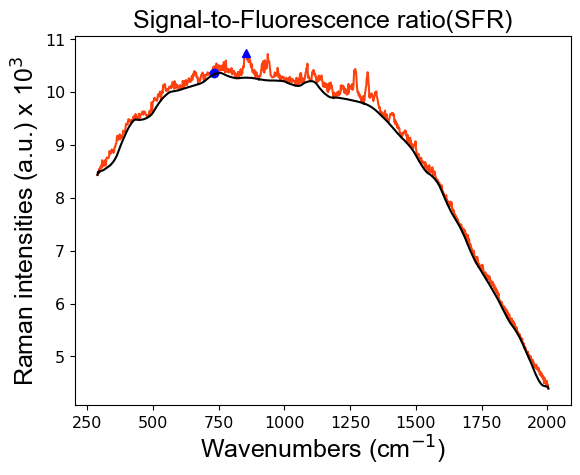

In [5]:
scale = 5           # scale of the DWT multilevel decomposition 
wavelet = 'sym5'    # mother wavelet
iterations = 100    # Bakcground removal iterations
spec = 1000
start = 10
plt.figsize=(15, 5)
tick_label_size = 11.43
name_size = 18
spectrum_bg_removed, bg_approx = dwt_iterative_bg_rm(specs_ex[spec, :][start:], wavelet, scale, iterations)
plt.plot(w_cm[start:], specs_ex[spec, :][start:]/1000, color='#FE420F')
plt.plot(w_cm[np.argmax(specs_ex[spec, :])], np.max(specs_ex[spec])/1000, '^', color='blue', label='Raman Maximum')
plt.plot(w_cm[np.argmax(bg_approx)], np.max(bg_approx)/1000, 'o', color='blue', label='Fluorescence Maximum')
plt.plot(w_cm[start:], bg_approx/1000, color='black')
plt.xlabel('Wavenumbers (cm$^{-1}$)', fontsize=name_size, font='Arial', labelpad=2)
plt.ylabel('Raman intensities (a.u.) x 10$^{3}$', fontsize=name_size, font='Arial', labelpad=2)
plt.title('Signal-to-Fluorescence ratio(SFR)', fontdict={'fontsize': name_size, 'fontname': 'Arial'})
plt.tick_params(axis='both', which='both', labelsize=tick_label_size)
# plt.savefig("/Users/mahsazarei/Grantlab Brugada Dropbox/Mahsa Zarei/A_Mahsa_Benchmarking_Data/manuscript_figures/signal_to_fluorescence.pdf" , dpi=800) 



<a id="dwt_all_spectra"></a>
### 1.1 Background subtraction using Discrete Wavelet Transform (DWT) - all spectra

In [6]:
specs_bg_removed = np.zeros(specs_ex.shape)
bg_approx = np.zeros(specs_ex.shape)
for spectrum in range(specs_ex.shape[0]):
    specs_bg_removed[spectrum, :], bg_approx[spectrum, :] = dwt_iterative_bg_rm(specs_ex[spectrum, :], wavelet, scale, iterations)


<a id="sfr_calculation"></a>
## 2. SFR calculation

In [7]:
SFR = []
for i in range(specs_bg_removed.shape[0]):
    SFR.append(np.divide(np.max(specs_bg_removed[i, :]), np.max(bg_approx[i, :])))
SFR_mean = np.mean(np.array(SFR))
SFR_mean

0.08968200973853203

<a id="snr_calculation"></a>
## 3. SNR calculation

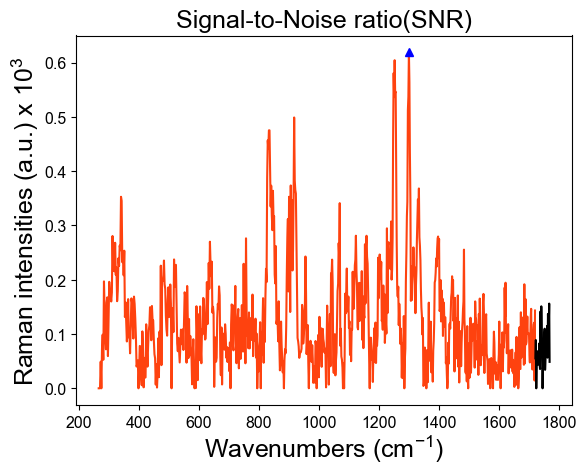

In [8]:
pivot1 = 805
pivot2 = 840
plt.figsize=(15, 5)
tick_label_size = 11.43
name_size = 18
plt.plot(w_cm[:pivot1], spectrum_bg_removed[ :pivot1]/1000, color='#FE420F')
plt.plot(w_cm[pivot1:pivot2:], spectrum_bg_removed[pivot1:pivot2:]/1000, color='black', label= 'Noise Region')
plt.plot(w_cm[np.argmax(spectrum_bg_removed)], np.max(spectrum_bg_removed)/1000, '^', color='blue', label= 'Maximum Raman')
plt.xlabel('Wavenumbers (cm$^\mathdefault{-1}$)', fontsize=name_size, font='Arial', labelpad=2)
plt.ylabel('Raman intensities (a.u.) x 10$^\mathdefault{3}$', fontsize=name_size, font='Arial', labelpad=2)
plt.xticks(fontname='Arial') 
plt.yticks(fontname='Arial')
plt.title('Signal-to-Noise ratio(SNR)', fontdict={'fontsize': name_size, 'fontname': 'Arial'})
plt.tick_params(axis='both', which='both', labelsize=tick_label_size) 

In [9]:
specs_norm = np.vstack([norm_mean(s) for s in specs_bg_removed])
SNR = []
for noisy_spec in specs_norm:
    SNR.append(np.divide(np.max(noisy_spec), np.std(noisy_spec[pivot1:pivot2])))
SNR_mean = np.mean(np.array(SNR))
SNR_std = np.std(np.array(SNR))
SNR_mean

22.881954351338422

<a id="z_score_normalization"></a>
## 4. Z-score normalization

In [10]:
specss = np.vstack([norm_mean(s) for s in specs_bg_removed])

<a id="averaging_replicas"></a>
## 5. Averaging replicas of each sample

In [11]:
specss_ave = np.vstack([np.mean(specss[names_ex==name, :], axis=0) for name in np.unique(names_ex)])
y_ave = np.vstack([np.mean(y_ex[names_ex==name, :], axis=0) for name in np.unique(names_ex)])

print(specss_ave.shape, y_ave.shape)

(48, 1024) (48, 6)


# Step 3: Modeling Table of Contents

- 1. [Partial Least Squares Regression (PLSR) optimal number of components - PRESS](#PRESS) 
- 1.1 [Partial Least Squares Regression (PLSR) - Leave-one-out cross validation & K-fold cv](#plsr)
- 2. [Convolutional Neural Network (CNN) - Leave-one-out cross validation & learning curve](#cnn)
- 3. [PLSR vs CNN calibration figure](#plsrvscnn)


<a id="PRESS"></a>
## 1. Partial Least Squares Regression (PLSR) optimal number of components - PRESS


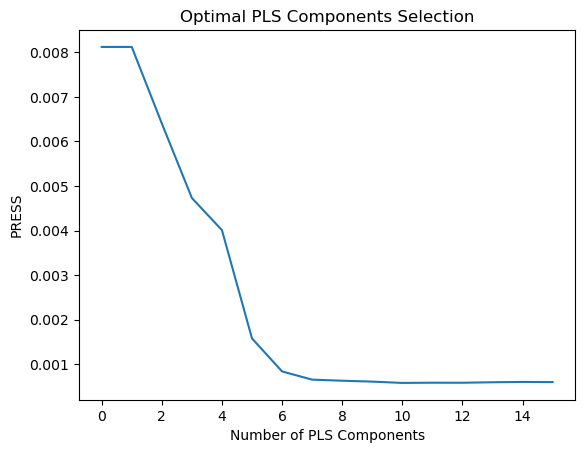

PLSR number of components with minimum MSE: 10


In [14]:
n_components_min_mse = select_optimal_pls_components(specss_ave, y_ave, max_components=15)
print("PLSR number of components with minimum MSE:", n_components_min_mse)

<a id="PRESS"></a>
## 1.1 Partial Least Squares Regression (PLSR) - Leave-one-out cross validation & K-fold cv

In [47]:
y_pred_cv_plsr = cross_val_predict(PLSRegression(n_components=9), specss_ave, y_ave, groups=np.unique(names_ex), cv=LeaveOneOut())
# y_pred_cv_plsr = cross_val_predict(PLSRegression(n_components=15), specss_m4, y_m4, cv=GroupKFold(n_splits=np.unique(names_ex).shape[0]))


r2:0.94, MSE:0.000582, MAE:0.018219
alanine
r2:0.96, MSE:0.000402, MAE:0.016411
asparagine
r2:0.88, MSE:0.001113, MAE:0.024747
aspartic acid
r2:0.90, MSE:0.000823, MAE:0.023293
glutamic acid
r2:0.96, MSE:0.000431, MAE:0.015141
histidine
r2:0.97, MSE:0.000346, MAE:0.014348
glucosamine
r2:0.95, MSE:0.000379, MAE:0.015372


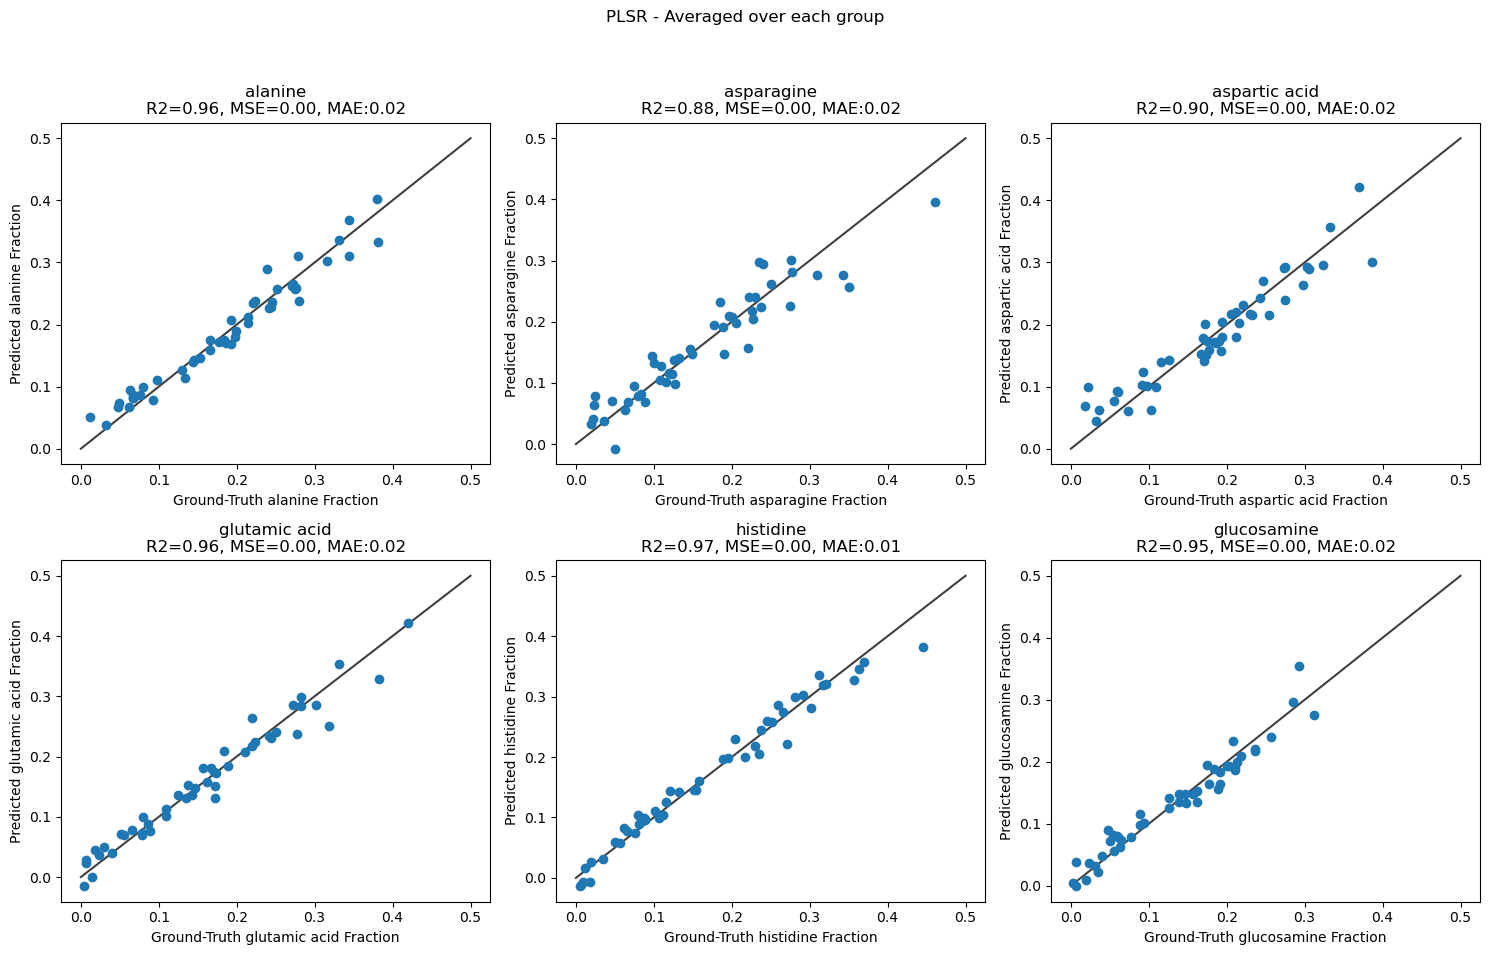

In [48]:
# For PLSR model results
plot_regression_results(y_ave, y_pred_cv_plsr, y_names, model_type='PLSR', title='PLSR Model Results')


<a id="cnn"></a>
## 2. Convolutional Neural Network (CNN) - Leave-one-out cross validation & learning curve

In [17]:
from tensorflow.keras.optimizers import Adam

model_cfg = {
    'compile': True,
    'opt': Adam(learning_rate=0.001)
}

num_filters = (16, 32, 64, 128) # Specify the number of filters for the convolutional layers
num_dense_filters = 32          # Specify the number of filters in the first dense layer

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

y_pred_cv_cnn_m4 = []
y_cv_cnn_m4 = []

for idx_train, idx_test in LeaveOneOut().split(specss_ave, y_ave, np.unique(names_ex)):
    model = cnn_AA_general(model_cfg, num_filters=num_filters, num_dense_filters=num_dense_filters)
    history = model.fit(np.expand_dims(specss_ave[idx_train, :], 2), y_ave[idx_train], epochs=50, batch_size=8, validation_data=(np.expand_dims(specss_ave[idx_test], 2), y_ave[idx_test]), callbacks=[es])
    y_pred_cv_cnn_m4.append(model.predict(np.expand_dims(specss_ave[idx_test], 2)))
    y_cv_cnn_m4.append(y_ave[idx_test])
    
y_pred_cv_cnn_m4 = np.vstack(y_pred_cv_cnn_m4)
y_cv_cnn_m4 = np.vstack(y_cv_cnn_m4)

# saved_predictios_path = '/Users/mahsazarei/Grantlab Brugada Dropbox/Mahsa Zarei/A_Mahsa_Benchmarking_Data/manuscript_figures/saved_predictions_CSVs'
# # Save y_pred_cv_cnn_m4 and y_cv_cnn_m4 to CSV
# np.savetxt(os.path.join(saved_predictios_path, 'y_pred_cv_cnn_m4.csv'), y_pred_cv_cnn_m4, delimiter=',')
# np.savetxt(os.path.join(saved_predictios_path, 'y_cv_cnn_m4.csv'), y_cv_cnn_m4, delimiter=',')


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 1022, 16)          64        
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 511, 16)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 509, 32)           1568      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 254, 32)          0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 252, 64)           6208      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 126, 64)         

Epoch 1/50
6/6 [==============================] - 1s 50ms/step - loss: 0.5261 - mse: 0.5261 - val_loss: 0.3129 - val_mse: 0.3129
Epoch 2/50
6/6 [==============================] - 0s 13ms/step - loss: 0.1244 - mse: 0.1244 - val_loss: 0.0152 - val_mse: 0.0152
Epoch 3/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0115 - mse: 0.0115 - val_loss: 0.0079 - val_mse: 0.0079
Epoch 4/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0082 - mse: 0.0082 - val_loss: 0.0076 - val_mse: 0.0076
Epoch 5/50
6/6 [==============================] - 0s 32ms/step - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0058 - val_mse: 0.0058
Epoch 6/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 7/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 8/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0027 - mse: 0.0027 - val

Epoch 1/50
6/6 [==============================] - 1s 52ms/step - loss: 0.8162 - mse: 0.8162 - val_loss: 0.4283 - val_mse: 0.4283
Epoch 2/50
6/6 [==============================] - 0s 14ms/step - loss: 0.1424 - mse: 0.1424 - val_loss: 0.0230 - val_mse: 0.0230
Epoch 3/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0179 - mse: 0.0179 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 4/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0094 - mse: 0.0094 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 5/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0058 - val_mse: 0.0058
Epoch 6/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 7/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0038 - mse: 0.0038 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 8/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0026 - mse: 0.0026 - val

Epoch 1/50
6/6 [==============================] - 1s 52ms/step - loss: 0.1730 - mse: 0.1730 - val_loss: 0.0749 - val_mse: 0.0749
Epoch 2/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0385 - mse: 0.0385 - val_loss: 0.0282 - val_mse: 0.0282
Epoch 3/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0131 - mse: 0.0131 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 4/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0080 - mse: 0.0080 - val_loss: 0.0155 - val_mse: 0.0155
Epoch 5/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 6/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0045 - mse: 0.0045 - val_loss: 0.0058 - val_mse: 0.0058
Epoch 7/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 8/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0023 - mse: 0.0023 - val

Epoch 1/50
6/6 [==============================] - 1s 47ms/step - loss: 0.1960 - mse: 0.1960 - val_loss: 0.0641 - val_mse: 0.0641
Epoch 2/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0461 - mse: 0.0461 - val_loss: 0.0199 - val_mse: 0.0199
Epoch 3/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0238 - mse: 0.0238 - val_loss: 0.0079 - val_mse: 0.0079
Epoch 4/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0121 - mse: 0.0121 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 5/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0076 - mse: 0.0076 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 6/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 7/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 8/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0036 - mse: 0.0036 - val

1/1 [==============================] - 0s 72ms/step
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_20 (Conv1D)          (None, 1022, 16)          64        
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 511, 16)          0         
 g1D)                                                            
                                                                 
 conv1d_21 (Conv1D)          (None, 509, 32)           1568      
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 254, 32)          0         
 g1D)                                                            
                                                                 
 conv1d_22 (Conv1D)          (None, 252, 64)           6208      
                                                                 
 m

Epoch 1/50
6/6 [==============================] - 1s 50ms/step - loss: 0.2968 - mse: 0.2968 - val_loss: 0.1903 - val_mse: 0.1903
Epoch 2/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0746 - mse: 0.0746 - val_loss: 0.0145 - val_mse: 0.0145
Epoch 3/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0115 - mse: 0.0115 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 4/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0073 - mse: 0.0073 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 5/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 6/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 6.2384e-04 - val_mse: 6.2384e-04
Epoch 7/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 8/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0019 - mse: 0.00

1/1 [==============================] - 0s 69ms/step
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_24 (Conv1D)          (None, 1022, 16)          64        
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 511, 16)          0         
 g1D)                                                            
                                                                 
 conv1d_25 (Conv1D)          (None, 509, 32)           1568      
                                                                 
 max_pooling1d_19 (MaxPoolin  (None, 254, 32)          0         
 g1D)                                                            
                                                                 
 conv1d_26 (Conv1D)          (None, 252, 64)           6208      
                                                                 
 m

Epoch 1/50
6/6 [==============================] - 1s 62ms/step - loss: 0.4450 - mse: 0.4450 - val_loss: 0.2411 - val_mse: 0.2411
Epoch 2/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0978 - mse: 0.0978 - val_loss: 0.0191 - val_mse: 0.0191
Epoch 3/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0142 - mse: 0.0142 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 4/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0087 - mse: 0.0087 - val_loss: 0.0081 - val_mse: 0.0081
Epoch 5/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0066 - mse: 0.0066 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 6/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 7/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0052 - val_mse: 0.0052
Epoch 8/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0024 - mse: 0.0024 - val

Epoch 1/50
6/6 [==============================] - 1s 60ms/step - loss: 0.2155 - mse: 0.2155 - val_loss: 0.0735 - val_mse: 0.0735
Epoch 2/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0525 - mse: 0.0525 - val_loss: 0.0077 - val_mse: 0.0077
Epoch 3/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0251 - val_mse: 0.0251
Epoch 4/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 5/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0072 - val_mse: 0.0072
Epoch 6/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 7/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 8/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0020 - mse: 0.0020 - val

Epoch 1/50
6/6 [==============================] - 1s 62ms/step - loss: 0.2836 - mse: 0.2836 - val_loss: 0.1304 - val_mse: 0.1304
Epoch 2/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0576 - mse: 0.0576 - val_loss: 0.0260 - val_mse: 0.0260
Epoch 3/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0140 - mse: 0.0140 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 4/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0090 - mse: 0.0090 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 5/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0067 - mse: 0.0067 - val_loss: 0.0050 - val_mse: 0.0050
Epoch 6/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 7/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 8/50
6/6 [==============================] - 0s 11ms/step - loss: 0.0030 - mse: 0.0030 - val

Epoch 1/50
6/6 [==============================] - 1s 59ms/step - loss: 0.0842 - mse: 0.0842 - val_loss: 0.0462 - val_mse: 0.0462
Epoch 2/50
6/6 [==============================] - 0s 21ms/step - loss: 0.0285 - mse: 0.0285 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 3/50
6/6 [==============================] - 0s 18ms/step - loss: 0.0080 - mse: 0.0080 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 4/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 5/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 6/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 9.1875e-04 - val_mse: 9.1875e-04
Epoch 7/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 8/50
6/6 [==============================] - 0s 15ms/step - loss: 9.5164e-04 - mse: 

Epoch 1/50
6/6 [==============================] - 1s 67ms/step - loss: 0.3272 - mse: 0.3272 - val_loss: 0.1626 - val_mse: 0.1626
Epoch 2/50
6/6 [==============================] - 0s 24ms/step - loss: 0.0651 - mse: 0.0651 - val_loss: 0.0229 - val_mse: 0.0229
Epoch 3/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0129 - mse: 0.0129 - val_loss: 0.0110 - val_mse: 0.0110
Epoch 4/50
6/6 [==============================] - 0s 18ms/step - loss: 0.0089 - mse: 0.0089 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 5/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0051 - mse: 0.0051 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 6/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 7/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 8/50
6/6 [==============================] - 0s 11ms/step - loss: 0.0018 - mse: 0.0018 - val

Epoch 1/50
6/6 [==============================] - 1s 72ms/step - loss: 0.4580 - mse: 0.4580 - val_loss: 0.1765 - val_mse: 0.1765
Epoch 2/50
6/6 [==============================] - 0s 20ms/step - loss: 0.0848 - mse: 0.0848 - val_loss: 0.0277 - val_mse: 0.0277
Epoch 3/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0170 - mse: 0.0170 - val_loss: 0.0233 - val_mse: 0.0233
Epoch 4/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0085 - mse: 0.0085 - val_loss: 0.0101 - val_mse: 0.0101
Epoch 5/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0067 - mse: 0.0067 - val_loss: 0.0134 - val_mse: 0.0134
Epoch 6/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0055 - mse: 0.0055 - val_loss: 0.0095 - val_mse: 0.0095
Epoch 7/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0077 - val_mse: 0.0077
Epoch 8/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0030 - mse: 0.0030 - val

Epoch 1/50
6/6 [==============================] - 1s 72ms/step - loss: 0.3181 - mse: 0.3181 - val_loss: 0.1623 - val_mse: 0.1623
Epoch 2/50
6/6 [==============================] - 0s 20ms/step - loss: 0.0654 - mse: 0.0654 - val_loss: 0.0260 - val_mse: 0.0260
Epoch 3/50
6/6 [==============================] - 0s 22ms/step - loss: 0.0155 - mse: 0.0155 - val_loss: 0.0138 - val_mse: 0.0138
Epoch 4/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0108 - mse: 0.0108 - val_loss: 0.0188 - val_mse: 0.0188
Epoch 5/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0073 - mse: 0.0073 - val_loss: 0.0103 - val_mse: 0.0103
Epoch 6/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0097 - val_mse: 0.0097
Epoch 7/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 8/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0024 - mse: 0.0024 - val

Epoch 1/50
6/6 [==============================] - 1s 179ms/step - loss: 0.6116 - mse: 0.6116 - val_loss: 0.3391 - val_mse: 0.3391
Epoch 2/50
6/6 [==============================] - 0s 13ms/step - loss: 0.1170 - mse: 0.1170 - val_loss: 0.0160 - val_mse: 0.0160
Epoch 3/50
6/6 [==============================] - 0s 20ms/step - loss: 0.0192 - mse: 0.0192 - val_loss: 0.0217 - val_mse: 0.0217
Epoch 4/50
6/6 [==============================] - 0s 19ms/step - loss: 0.0110 - mse: 0.0110 - val_loss: 0.0139 - val_mse: 0.0139
Epoch 5/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0106 - val_mse: 0.0106
Epoch 6/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0099 - val_mse: 0.0099
Epoch 7/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 8/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0025 - mse: 0.0025 - va

Epoch 1/50
6/6 [==============================] - 1s 75ms/step - loss: 0.1575 - mse: 0.1575 - val_loss: 0.0505 - val_mse: 0.0505
Epoch 2/50
6/6 [==============================] - 0s 21ms/step - loss: 0.0318 - mse: 0.0318 - val_loss: 0.0170 - val_mse: 0.0170
Epoch 3/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0095 - mse: 0.0095 - val_loss: 0.0058 - val_mse: 0.0058
Epoch 4/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0063 - val_mse: 0.0063
Epoch 5/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 6/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 7/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 8/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0016 - mse: 0.0016 - val

Epoch 1/50
6/6 [==============================] - 1s 72ms/step - loss: 0.4432 - mse: 0.4432 - val_loss: 0.2040 - val_mse: 0.2040
Epoch 2/50
6/6 [==============================] - 0s 20ms/step - loss: 0.0950 - mse: 0.0950 - val_loss: 0.0133 - val_mse: 0.0133
Epoch 3/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0216 - mse: 0.0216 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 4/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0082 - val_mse: 0.0082
Epoch 5/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0075 - mse: 0.0075 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 6/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 7/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 8/50
6/6 [==============================] - 0s 11ms/step - loss: 0.0030 - mse: 0.0030 - val

Epoch 1/50
6/6 [==============================] - 1s 64ms/step - loss: 0.1163 - mse: 0.1163 - val_loss: 0.0474 - val_mse: 0.0474
Epoch 2/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0376 - mse: 0.0376 - val_loss: 0.0329 - val_mse: 0.0329
Epoch 3/50
6/6 [==============================] - 0s 11ms/step - loss: 0.0130 - mse: 0.0130 - val_loss: 0.0128 - val_mse: 0.0128
Epoch 4/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 5/50
6/6 [==============================] - 0s 21ms/step - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 6/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0051 - val_mse: 0.0051
Epoch 7/50
6/6 [==============================] - 0s 11ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0063 - val_mse: 0.0063
Epoch 8/50
6/6 [==============================] - 0s 11ms/step - loss: 0.0020 - mse: 0.0020 - val

Epoch 1/50
6/6 [==============================] - 1s 75ms/step - loss: 0.3944 - mse: 0.3944 - val_loss: 0.1978 - val_mse: 0.1978
Epoch 2/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0970 - mse: 0.0970 - val_loss: 0.0151 - val_mse: 0.0151
Epoch 3/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0116 - mse: 0.0116 - val_loss: 0.0050 - val_mse: 0.0050
Epoch 4/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0091 - mse: 0.0091 - val_loss: 0.0061 - val_mse: 0.0061
Epoch 5/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0074 - mse: 0.0074 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 6/50
6/6 [==============================] - 0s 20ms/step - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 7/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 8/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0024 - mse: 0.0024 - val

Epoch 1/50
6/6 [==============================] - 1s 104ms/step - loss: 0.4657 - mse: 0.4657 - val_loss: 0.1573 - val_mse: 0.1573
Epoch 2/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0972 - mse: 0.0972 - val_loss: 0.0255 - val_mse: 0.0255
Epoch 3/50
6/6 [==============================] - 0s 19ms/step - loss: 0.0170 - mse: 0.0170 - val_loss: 0.0051 - val_mse: 0.0051
Epoch 4/50
6/6 [==============================] - 0s 19ms/step - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0112 - val_mse: 0.0112
Epoch 5/50
6/6 [==============================] - 0s 18ms/step - loss: 0.0091 - mse: 0.0091 - val_loss: 0.0055 - val_mse: 0.0055
Epoch 6/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0068 - mse: 0.0068 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 7/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0031 - val_mse: 0.0031
Epoch 8/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0035 - mse: 0.0035 - va

Epoch 1/50
6/6 [==============================] - 1s 98ms/step - loss: 0.1748 - mse: 0.1748 - val_loss: 0.0834 - val_mse: 0.0834
Epoch 2/50
6/6 [==============================] - 0s 18ms/step - loss: 0.0425 - mse: 0.0425 - val_loss: 0.0085 - val_mse: 0.0085
Epoch 3/50
6/6 [==============================] - 0s 18ms/step - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0076 - val_mse: 0.0076
Epoch 4/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0080 - mse: 0.0080 - val_loss: 0.0053 - val_mse: 0.0053
Epoch 5/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0066 - mse: 0.0066 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 6/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 7/50
6/6 [==============================] - 0s 18ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 8/50
6/6 [==============================] - 0s 21ms/step - loss: 0.0022 - mse: 0.0022 - val

Epoch 1/50
6/6 [==============================] - 1s 97ms/step - loss: 0.4430 - mse: 0.4430 - val_loss: 0.2430 - val_mse: 0.2430
Epoch 2/50
6/6 [==============================] - 0s 33ms/step - loss: 0.1206 - mse: 0.1206 - val_loss: 0.0116 - val_mse: 0.0116
Epoch 3/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0145 - mse: 0.0145 - val_loss: 0.0082 - val_mse: 0.0082
Epoch 4/50
6/6 [==============================] - 0s 21ms/step - loss: 0.0100 - mse: 0.0100 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 5/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0087 - mse: 0.0087 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 6/50
6/6 [==============================] - 0s 18ms/step - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 7/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 8/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0046 - mse: 0.0046 - val

Epoch 1/50
6/6 [==============================] - 1s 90ms/step - loss: 0.8355 - mse: 0.8355 - val_loss: 0.4837 - val_mse: 0.4837
Epoch 2/50
6/6 [==============================] - 0s 21ms/step - loss: 0.1713 - mse: 0.1713 - val_loss: 0.0207 - val_mse: 0.0207
Epoch 3/50
6/6 [==============================] - 0s 23ms/step - loss: 0.0206 - mse: 0.0206 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 4/50
6/6 [==============================] - 0s 21ms/step - loss: 0.0101 - mse: 0.0101 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 5/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0074 - mse: 0.0074 - val_loss: 0.0051 - val_mse: 0.0051
Epoch 6/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 7/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 8/50
6/6 [==============================] - 0s 11ms/step - loss: 0.0028 - mse: 0.0028 - val

Epoch 1/50
6/6 [==============================] - 1s 93ms/step - loss: 0.2329 - mse: 0.2329 - val_loss: 0.0857 - val_mse: 0.0857
Epoch 2/50
6/6 [==============================] - 0s 19ms/step - loss: 0.0496 - mse: 0.0496 - val_loss: 0.0143 - val_mse: 0.0143
Epoch 3/50
6/6 [==============================] - 0s 18ms/step - loss: 0.0154 - mse: 0.0154 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 4/50
6/6 [==============================] - 0s 23ms/step - loss: 0.0096 - mse: 0.0096 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 5/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0064 - mse: 0.0064 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 6/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 7/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 8/50
6/6 [==============================] - 0s 11ms/step - loss: 0.0024 - mse: 0.0024 - val

Epoch 1/50
6/6 [==============================] - 1s 100ms/step - loss: 0.2699 - mse: 0.2699 - val_loss: 0.1528 - val_mse: 0.1528
Epoch 2/50
6/6 [==============================] - 0s 28ms/step - loss: 0.0556 - mse: 0.0556 - val_loss: 0.0194 - val_mse: 0.0194
Epoch 3/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0115 - mse: 0.0115 - val_loss: 0.0081 - val_mse: 0.0081
Epoch 4/50
6/6 [==============================] - 0s 11ms/step - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0120 - val_mse: 0.0120
Epoch 5/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 6/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 7/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 4.9365e-04 - val_mse: 4.9365e-04
Epoch 8/50
6/6 [==============================] - 0s 23ms/step - loss: 0.0014 - mse: 0.0

Epoch 1/50
6/6 [==============================] - 2s 228ms/step - loss: 0.2576 - mse: 0.2576 - val_loss: 0.1348 - val_mse: 0.1348
Epoch 2/50
6/6 [==============================] - 0s 22ms/step - loss: 0.0708 - mse: 0.0708 - val_loss: 0.0231 - val_mse: 0.0231
Epoch 3/50
6/6 [==============================] - 0s 27ms/step - loss: 0.0173 - mse: 0.0173 - val_loss: 0.0143 - val_mse: 0.0143
Epoch 4/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0100 - mse: 0.0100 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 5/50
6/6 [==============================] - 0s 19ms/step - loss: 0.0073 - mse: 0.0073 - val_loss: 0.0074 - val_mse: 0.0074
Epoch 6/50
6/6 [==============================] - 0s 21ms/step - loss: 0.0051 - mse: 0.0051 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 7/50
6/6 [==============================] - 0s 11ms/step - loss: 0.0038 - mse: 0.0038 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 8/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0025 - mse: 0.0025 - va

Epoch 1/50
6/6 [==============================] - 1s 89ms/step - loss: 0.2239 - mse: 0.2239 - val_loss: 0.1374 - val_mse: 0.1374
Epoch 2/50
6/6 [==============================] - 0s 25ms/step - loss: 0.0596 - mse: 0.0596 - val_loss: 0.0062 - val_mse: 0.0062
Epoch 3/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0106 - mse: 0.0106 - val_loss: 0.0104 - val_mse: 0.0104
Epoch 4/50
6/6 [==============================] - 0s 19ms/step - loss: 0.0074 - mse: 0.0074 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 5/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0053 - mse: 0.0053 - val_loss: 0.0053 - val_mse: 0.0053
Epoch 6/50
6/6 [==============================] - 0s 18ms/step - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 7/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 8/50
6/6 [==============================] - 0s 11ms/step - loss: 0.0024 - mse: 0.0024 - val

Epoch 1/50
6/6 [==============================] - 1s 107ms/step - loss: 0.2675 - mse: 0.2675 - val_loss: 0.1959 - val_mse: 0.1959
Epoch 2/50
6/6 [==============================] - 0s 25ms/step - loss: 0.0552 - mse: 0.0552 - val_loss: 0.0152 - val_mse: 0.0152
Epoch 3/50
6/6 [==============================] - 0s 24ms/step - loss: 0.0128 - mse: 0.0128 - val_loss: 0.0196 - val_mse: 0.0196
Epoch 4/50
6/6 [==============================] - 0s 24ms/step - loss: 0.0096 - mse: 0.0096 - val_loss: 0.0209 - val_mse: 0.0209
Epoch 5/50
6/6 [==============================] - 0s 18ms/step - loss: 0.0075 - mse: 0.0075 - val_loss: 0.0157 - val_mse: 0.0157
Epoch 6/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0121 - val_mse: 0.0121
Epoch 7/50
6/6 [==============================] - 0s 20ms/step - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0071 - val_mse: 0.0071
Epoch 8/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0025 - mse: 0.0025 - va

Epoch 1/50
6/6 [==============================] - 1s 97ms/step - loss: 0.9302 - mse: 0.9302 - val_loss: 0.7411 - val_mse: 0.7411
Epoch 2/50
6/6 [==============================] - 0s 22ms/step - loss: 0.2082 - mse: 0.2082 - val_loss: 0.0503 - val_mse: 0.0503
Epoch 3/50
6/6 [==============================] - 0s 20ms/step - loss: 0.0212 - mse: 0.0212 - val_loss: 0.0129 - val_mse: 0.0129
Epoch 4/50
6/6 [==============================] - 0s 21ms/step - loss: 0.0116 - mse: 0.0116 - val_loss: 0.0176 - val_mse: 0.0176
Epoch 5/50
6/6 [==============================] - 0s 23ms/step - loss: 0.0092 - mse: 0.0092 - val_loss: 0.0127 - val_mse: 0.0127
Epoch 6/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0113 - val_mse: 0.0113
Epoch 7/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0074 - val_mse: 0.0074
Epoch 8/50
6/6 [==============================] - 0s 11ms/step - loss: 0.0032 - mse: 0.0032 - val

Epoch 1/50
6/6 [==============================] - 1s 102ms/step - loss: 0.7228 - mse: 0.7228 - val_loss: 0.3967 - val_mse: 0.3967
Epoch 2/50
6/6 [==============================] - 0s 19ms/step - loss: 0.1557 - mse: 0.1557 - val_loss: 0.0222 - val_mse: 0.0222
Epoch 3/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0126 - mse: 0.0126 - val_loss: 0.0115 - val_mse: 0.0115
Epoch 4/50
6/6 [==============================] - 0s 19ms/step - loss: 0.0083 - mse: 0.0083 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 5/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0049 - val_mse: 0.0049
Epoch 6/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0055 - val_mse: 0.0055
Epoch 7/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 8/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0022 - mse: 0.0022 - va

Epoch 1/50
6/6 [==============================] - 1s 97ms/step - loss: 0.0966 - mse: 0.0966 - val_loss: 0.0423 - val_mse: 0.0423
Epoch 2/50
6/6 [==============================] - 0s 28ms/step - loss: 0.0324 - mse: 0.0324 - val_loss: 0.0073 - val_mse: 0.0073
Epoch 3/50
6/6 [==============================] - 0s 26ms/step - loss: 0.0108 - mse: 0.0108 - val_loss: 0.0093 - val_mse: 0.0093
Epoch 4/50
6/6 [==============================] - 0s 19ms/step - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 5/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0031 - val_mse: 0.0031
Epoch 6/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0045 - mse: 0.0045 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 7/50
6/6 [==============================] - 0s 19ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 8.9942e-04 - val_mse: 8.9942e-04
Epoch 8/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0022 - mse: 0.00

Epoch 1/50
6/6 [==============================] - 1s 94ms/step - loss: 0.2504 - mse: 0.2504 - val_loss: 0.1113 - val_mse: 0.1113
Epoch 2/50
6/6 [==============================] - 0s 18ms/step - loss: 0.0688 - mse: 0.0688 - val_loss: 0.0210 - val_mse: 0.0210
Epoch 3/50
6/6 [==============================] - 0s 21ms/step - loss: 0.0115 - mse: 0.0115 - val_loss: 0.0053 - val_mse: 0.0053
Epoch 4/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0081 - mse: 0.0081 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 5/50
6/6 [==============================] - 0s 24ms/step - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0053 - val_mse: 0.0053
Epoch 6/50
6/6 [==============================] - 0s 19ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 7/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 8/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0021 - mse: 0.0021 - val

Epoch 1/50
6/6 [==============================] - 1s 94ms/step - loss: 0.1117 - mse: 0.1117 - val_loss: 0.0605 - val_mse: 0.0605
Epoch 2/50
6/6 [==============================] - 0s 26ms/step - loss: 0.0437 - mse: 0.0437 - val_loss: 0.0181 - val_mse: 0.0181
Epoch 3/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0131 - mse: 0.0131 - val_loss: 0.0114 - val_mse: 0.0114
Epoch 4/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0071 - mse: 0.0071 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 5/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 6/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 7/50
6/6 [==============================] - 0s 11ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 8/50
6/6 [==============================] - 0s 19ms/step - loss: 0.0014 - mse: 0.0014 - val

Epoch 1/50
6/6 [==============================] - 1s 95ms/step - loss: 0.5919 - mse: 0.5919 - val_loss: 0.3299 - val_mse: 0.3299
Epoch 2/50
6/6 [==============================] - 0s 24ms/step - loss: 0.1346 - mse: 0.1346 - val_loss: 0.0161 - val_mse: 0.0161
Epoch 3/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0134 - mse: 0.0134 - val_loss: 0.0062 - val_mse: 0.0062
Epoch 4/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0096 - mse: 0.0096 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 5/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0077 - mse: 0.0077 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 6/50
6/6 [==============================] - 0s 18ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0063 - val_mse: 0.0063
Epoch 7/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0031 - val_mse: 0.0031
Epoch 8/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0032 - mse: 0.0032 - val

Epoch 1/50
6/6 [==============================] - 1s 92ms/step - loss: 0.3450 - mse: 0.3450 - val_loss: 0.0699 - val_mse: 0.0699
Epoch 2/50
6/6 [==============================] - 0s 28ms/step - loss: 0.0502 - mse: 0.0502 - val_loss: 0.0298 - val_mse: 0.0298
Epoch 3/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0202 - mse: 0.0202 - val_loss: 0.0076 - val_mse: 0.0076
Epoch 4/50
6/6 [==============================] - 0s 20ms/step - loss: 0.0096 - mse: 0.0096 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 5/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0084 - mse: 0.0084 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 6/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 7/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0045 - mse: 0.0045 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 8/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0031 - mse: 0.0031 - val

Epoch 1/50
6/6 [==============================] - 1s 101ms/step - loss: 0.4044 - mse: 0.4044 - val_loss: 0.1696 - val_mse: 0.1696
Epoch 2/50
6/6 [==============================] - 0s 31ms/step - loss: 0.0859 - mse: 0.0859 - val_loss: 0.0244 - val_mse: 0.0244
Epoch 3/50
6/6 [==============================] - 0s 25ms/step - loss: 0.0173 - mse: 0.0173 - val_loss: 0.0078 - val_mse: 0.0078
Epoch 4/50
6/6 [==============================] - 0s 21ms/step - loss: 0.0096 - mse: 0.0096 - val_loss: 0.0047 - val_mse: 0.0047
Epoch 5/50
6/6 [==============================] - 0s 28ms/step - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 6/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 7/50
6/6 [==============================] - 0s 22ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 8.7505e-04 - val_mse: 8.7505e-04
Epoch 8/50
6/6 [==============================] - 0s 22ms/step - loss: 0.0018 - mse: 0.0

Epoch 1/50
6/6 [==============================] - 2s 122ms/step - loss: 0.1838 - mse: 0.1838 - val_loss: 0.0896 - val_mse: 0.0896
Epoch 2/50
6/6 [==============================] - 0s 34ms/step - loss: 0.0470 - mse: 0.0470 - val_loss: 0.0313 - val_mse: 0.0313
Epoch 3/50
6/6 [==============================] - 0s 24ms/step - loss: 0.0124 - mse: 0.0124 - val_loss: 0.0179 - val_mse: 0.0179
Epoch 4/50
6/6 [==============================] - 0s 21ms/step - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0139 - val_mse: 0.0139
Epoch 5/50
6/6 [==============================] - 0s 22ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0106 - val_mse: 0.0106
Epoch 6/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0082 - val_mse: 0.0082
Epoch 7/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0082 - val_mse: 0.0082
Epoch 8/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0014 - mse: 0.0014 - va

Epoch 1/50
6/6 [==============================] - 1s 99ms/step - loss: 0.5983 - mse: 0.5983 - val_loss: 0.1912 - val_mse: 0.1912
Epoch 2/50
6/6 [==============================] - 0s 19ms/step - loss: 0.1052 - mse: 0.1052 - val_loss: 0.0340 - val_mse: 0.0340
Epoch 3/50
6/6 [==============================] - 0s 28ms/step - loss: 0.0169 - mse: 0.0169 - val_loss: 0.0159 - val_mse: 0.0159
Epoch 4/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0119 - mse: 0.0119 - val_loss: 0.0155 - val_mse: 0.0155
Epoch 5/50
6/6 [==============================] - 0s 45ms/step - loss: 0.0112 - mse: 0.0112 - val_loss: 0.0155 - val_mse: 0.0155
Epoch 6/50
6/6 [==============================] - 0s 25ms/step - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 7/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0053 - mse: 0.0053 - val_loss: 0.0079 - val_mse: 0.0079
Epoch 8/50
6/6 [==============================] - 0s 25ms/step - loss: 0.0038 - mse: 0.0038 - val

Epoch 1/50
6/6 [==============================] - 1s 108ms/step - loss: 0.2268 - mse: 0.2268 - val_loss: 0.0918 - val_mse: 0.0918
Epoch 2/50
6/6 [==============================] - 0s 43ms/step - loss: 0.0518 - mse: 0.0518 - val_loss: 0.0157 - val_mse: 0.0157
Epoch 3/50
6/6 [==============================] - 0s 31ms/step - loss: 0.0148 - mse: 0.0148 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 4/50
6/6 [==============================] - 0s 29ms/step - loss: 0.0091 - mse: 0.0091 - val_loss: 9.0671e-04 - val_mse: 9.0671e-04
Epoch 5/50
6/6 [==============================] - 0s 20ms/step - loss: 0.0064 - mse: 0.0064 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 6/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 5.4518e-04 - val_mse: 5.4518e-04
Epoch 7/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 4.2176e-04 - val_mse: 4.2176e-04
Epoch 8/50
6/6 [==============================] - 0s 14ms/step - loss: 0

Epoch 1/50
6/6 [==============================] - 1s 117ms/step - loss: 0.1687 - mse: 0.1687 - val_loss: 0.0717 - val_mse: 0.0717
Epoch 2/50
6/6 [==============================] - 0s 39ms/step - loss: 0.0451 - mse: 0.0451 - val_loss: 0.0128 - val_mse: 0.0128
Epoch 3/50
6/6 [==============================] - 0s 35ms/step - loss: 0.0102 - mse: 0.0102 - val_loss: 0.0080 - val_mse: 0.0080
Epoch 4/50
6/6 [==============================] - 0s 22ms/step - loss: 0.0073 - mse: 0.0073 - val_loss: 0.0061 - val_mse: 0.0061
Epoch 5/50
6/6 [==============================] - 0s 36ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 6/50
6/6 [==============================] - 0s 29ms/step - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 7/50
6/6 [==============================] - 0s 19ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 8/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0020 - mse: 0.0020 - va

Epoch 1/50
6/6 [==============================] - 1s 126ms/step - loss: 0.2316 - mse: 0.2316 - val_loss: 0.1066 - val_mse: 0.1066
Epoch 2/50
6/6 [==============================] - 0s 28ms/step - loss: 0.0592 - mse: 0.0592 - val_loss: 0.0158 - val_mse: 0.0158
Epoch 3/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0113 - mse: 0.0113 - val_loss: 0.0081 - val_mse: 0.0081
Epoch 4/50
6/6 [==============================] - 0s 27ms/step - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 5/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 6/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 7/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 5.5598e-04 - val_mse: 5.5598e-04
Epoch 8/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0012 - mse: 0.0

Epoch 1/50
6/6 [==============================] - 1s 134ms/step - loss: 0.5239 - mse: 0.5239 - val_loss: 0.2900 - val_mse: 0.2900
Epoch 2/50
6/6 [==============================] - 0s 27ms/step - loss: 0.1298 - mse: 0.1298 - val_loss: 0.0266 - val_mse: 0.0266
Epoch 3/50
6/6 [==============================] - 0s 24ms/step - loss: 0.0167 - mse: 0.0167 - val_loss: 0.0112 - val_mse: 0.0112
Epoch 4/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0102 - mse: 0.0102 - val_loss: 0.0109 - val_mse: 0.0109
Epoch 5/50
6/6 [==============================] - 0s 20ms/step - loss: 0.0077 - mse: 0.0077 - val_loss: 0.0103 - val_mse: 0.0103
Epoch 6/50
6/6 [==============================] - 0s 26ms/step - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 7/50
6/6 [==============================] - 0s 30ms/step - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 8/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0025 - mse: 0.0025 - va

Epoch 1/50
6/6 [==============================] - 1s 154ms/step - loss: 0.2042 - mse: 0.2042 - val_loss: 0.1167 - val_mse: 0.1167
Epoch 2/50
6/6 [==============================] - 0s 22ms/step - loss: 0.0528 - mse: 0.0528 - val_loss: 0.0188 - val_mse: 0.0188
Epoch 3/50
6/6 [==============================] - 0s 19ms/step - loss: 0.0141 - mse: 0.0141 - val_loss: 0.0129 - val_mse: 0.0129
Epoch 4/50
6/6 [==============================] - 0s 22ms/step - loss: 0.0088 - mse: 0.0088 - val_loss: 0.0078 - val_mse: 0.0078
Epoch 5/50
6/6 [==============================] - 0s 22ms/step - loss: 0.0075 - mse: 0.0075 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 6/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0051 - mse: 0.0051 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 7/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0010 - val_mse: 0.0010
Epoch 8/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0024 - mse: 0.0024 - va

Epoch 1/50
6/6 [==============================] - 1s 128ms/step - loss: 0.1496 - mse: 0.1496 - val_loss: 0.0904 - val_mse: 0.0904
Epoch 2/50
6/6 [==============================] - 0s 35ms/step - loss: 0.0434 - mse: 0.0434 - val_loss: 0.0074 - val_mse: 0.0074
Epoch 3/50
6/6 [==============================] - 0s 21ms/step - loss: 0.0101 - mse: 0.0101 - val_loss: 0.0077 - val_mse: 0.0077
Epoch 4/50
6/6 [==============================] - 0s 31ms/step - loss: 0.0067 - mse: 0.0067 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 5/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 6/50
6/6 [==============================] - 0s 18ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 7/50
6/6 [==============================] - 0s 18ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 8/50
6/6 [==============================] - 0s 18ms/step - loss: 0.0017 - mse: 0.0017 - va

Epoch 1/50
6/6 [==============================] - 1s 131ms/step - loss: 0.3086 - mse: 0.3086 - val_loss: 0.0860 - val_mse: 0.0860
Epoch 2/50
6/6 [==============================] - 0s 48ms/step - loss: 0.0649 - mse: 0.0649 - val_loss: 0.0245 - val_mse: 0.0245
Epoch 3/50
6/6 [==============================] - 0s 21ms/step - loss: 0.0171 - mse: 0.0171 - val_loss: 0.0073 - val_mse: 0.0073
Epoch 4/50
6/6 [==============================] - 0s 25ms/step - loss: 0.0096 - mse: 0.0096 - val_loss: 0.0154 - val_mse: 0.0154
Epoch 5/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0073 - mse: 0.0073 - val_loss: 0.0073 - val_mse: 0.0073
Epoch 6/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 7/50
6/6 [==============================] - 0s 21ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 8/50
6/6 [==============================] - 0s 27ms/step - loss: 0.0025 - mse: 0.0025 - va

Epoch 1/50
6/6 [==============================] - 1s 111ms/step - loss: 0.0951 - mse: 0.0951 - val_loss: 0.0478 - val_mse: 0.0478
Epoch 2/50
6/6 [==============================] - 0s 37ms/step - loss: 0.0365 - mse: 0.0365 - val_loss: 0.0182 - val_mse: 0.0182
Epoch 3/50
6/6 [==============================] - 0s 26ms/step - loss: 0.0126 - mse: 0.0126 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 4/50
6/6 [==============================] - 0s 37ms/step - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 5/50
6/6 [==============================] - 0s 25ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 6/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 7/50
6/6 [==============================] - 0s 11ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 8/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0021 - mse: 0.0021 - va

Epoch 1/50
6/6 [==============================] - 1s 112ms/step - loss: 0.1567 - mse: 0.1567 - val_loss: 0.0473 - val_mse: 0.0473
Epoch 2/50
6/6 [==============================] - 0s 37ms/step - loss: 0.0357 - mse: 0.0357 - val_loss: 0.0352 - val_mse: 0.0352
Epoch 3/50
6/6 [==============================] - 0s 26ms/step - loss: 0.0108 - mse: 0.0108 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 4/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0066 - mse: 0.0066 - val_loss: 0.0132 - val_mse: 0.0132
Epoch 5/50
6/6 [==============================] - 0s 28ms/step - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0095 - val_mse: 0.0095
Epoch 6/50
6/6 [==============================] - 0s 32ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0098 - val_mse: 0.0098
Epoch 7/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 8/50
6/6 [==============================] - 0s 30ms/step - loss: 0.0018 - mse: 0.0018 - va

Epoch 1/50
6/6 [==============================] - 2s 130ms/step - loss: 0.1891 - mse: 0.1891 - val_loss: 0.0948 - val_mse: 0.0948
Epoch 2/50
6/6 [==============================] - 0s 35ms/step - loss: 0.0496 - mse: 0.0496 - val_loss: 0.0185 - val_mse: 0.0185
Epoch 3/50
6/6 [==============================] - 0s 34ms/step - loss: 0.0129 - mse: 0.0129 - val_loss: 0.0072 - val_mse: 0.0072
Epoch 4/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0090 - mse: 0.0090 - val_loss: 0.0072 - val_mse: 0.0072
Epoch 5/50
6/6 [==============================] - 0s 30ms/step - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0049 - val_mse: 0.0049
Epoch 6/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0050 - val_mse: 0.0050
Epoch 7/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 8/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0025 - mse: 0.0025 - va

Epoch 1/50
6/6 [==============================] - 1s 143ms/step - loss: 0.2198 - mse: 0.2198 - val_loss: 0.1343 - val_mse: 0.1343
Epoch 2/50
6/6 [==============================] - 0s 22ms/step - loss: 0.0643 - mse: 0.0643 - val_loss: 0.0174 - val_mse: 0.0174
Epoch 3/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0123 - mse: 0.0123 - val_loss: 0.0143 - val_mse: 0.0143
Epoch 4/50
6/6 [==============================] - 0s 40ms/step - loss: 0.0083 - mse: 0.0083 - val_loss: 0.0108 - val_mse: 0.0108
Epoch 5/50
6/6 [==============================] - 0s 21ms/step - loss: 0.0068 - mse: 0.0068 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 6/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 7/50
6/6 [==============================] - 0s 18ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 8/50
6/6 [==============================] - 0s 18ms/step - loss: 0.0021 - mse: 0.0021 - va

Epoch 1/50
6/6 [==============================] - 1s 119ms/step - loss: 0.1770 - mse: 0.1770 - val_loss: 0.0840 - val_mse: 0.0840
Epoch 2/50
6/6 [==============================] - 0s 35ms/step - loss: 0.0458 - mse: 0.0458 - val_loss: 0.0075 - val_mse: 0.0075
Epoch 3/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0125 - mse: 0.0125 - val_loss: 0.0074 - val_mse: 0.0074
Epoch 4/50
6/6 [==============================] - 0s 59ms/step - loss: 0.0089 - mse: 0.0089 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 5/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0053 - mse: 0.0053 - val_loss: 0.0031 - val_mse: 0.0031
Epoch 6/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 7/50
6/6 [==============================] - 0s 20ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 9.6725e-04 - val_mse: 9.6725e-04
Epoch 8/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0014 - mse: 0.0

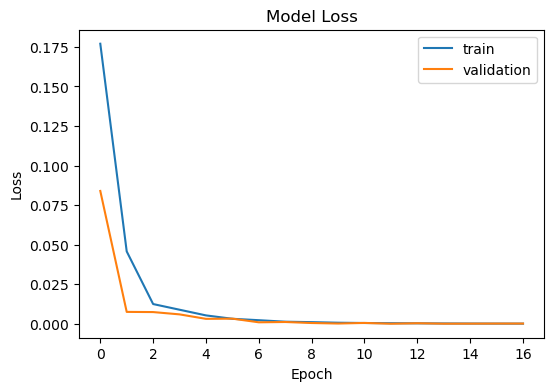

In [39]:
plot_learning_curve(history, metric='loss', title='Model Loss', figsize=(6, 4))

r2:0.91, MSE:0.000845, MAE:0.020892
alanine
r2:0.96, MSE:0.000352, MAE:0.014539
asparagine
r2:0.80, MSE:0.001873, MAE:0.030738
aspartic acid
r2:0.89, MSE:0.000917, MAE:0.023944
glutamic acid
r2:0.93, MSE:0.000776, MAE:0.021474
histidine
r2:0.98, MSE:0.000269, MAE:0.013158
glucosamine
r2:0.87, MSE:0.000881, MAE:0.021499


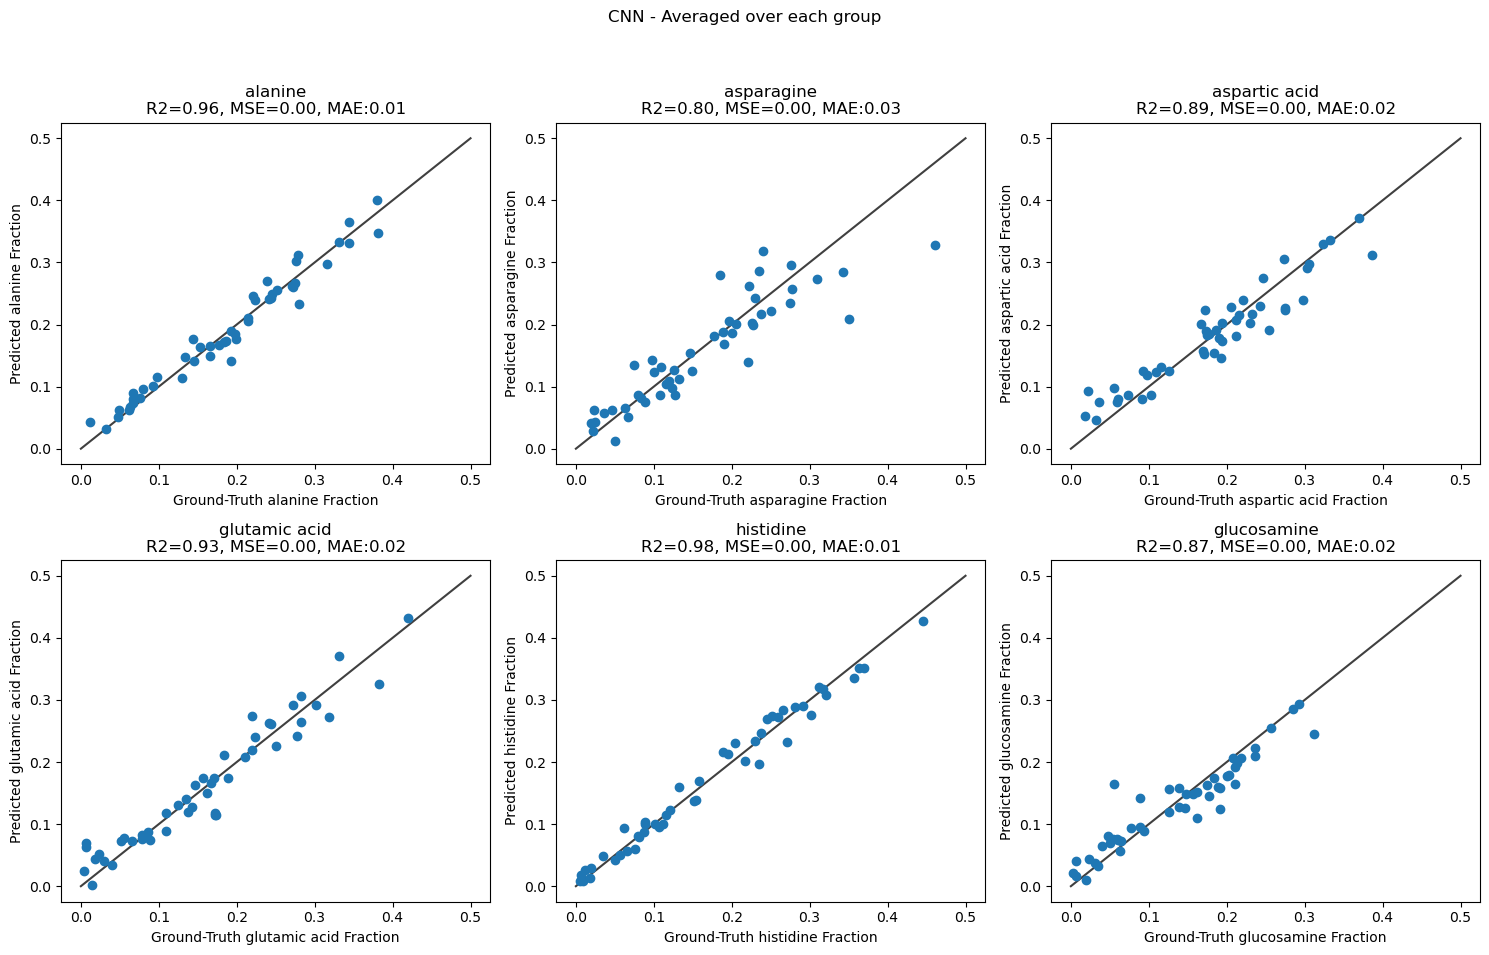

In [40]:
# # Load the arrays from CSV
# y_pred_cv_cnn_m4 = np.loadtxt(os.path.join(saved_predictios_path, 'y_pred_cv_cnn_m4.csv'), delimiter=',')
# y_cv_cnn_m4 = np.loadtxt(os.path.join(saved_predictios_path, 'y_cv_cnn_m4.csv'), delimiter=',')

# For CNN model results
plot_regression_results(y_cv_cnn_m4, y_pred_cv_cnn_m4, y_names, model_type='CNN', title='CNN Model Results')



<a id="plsrvscnn"></a>
## 3. PLSR vs CNN calibration figure

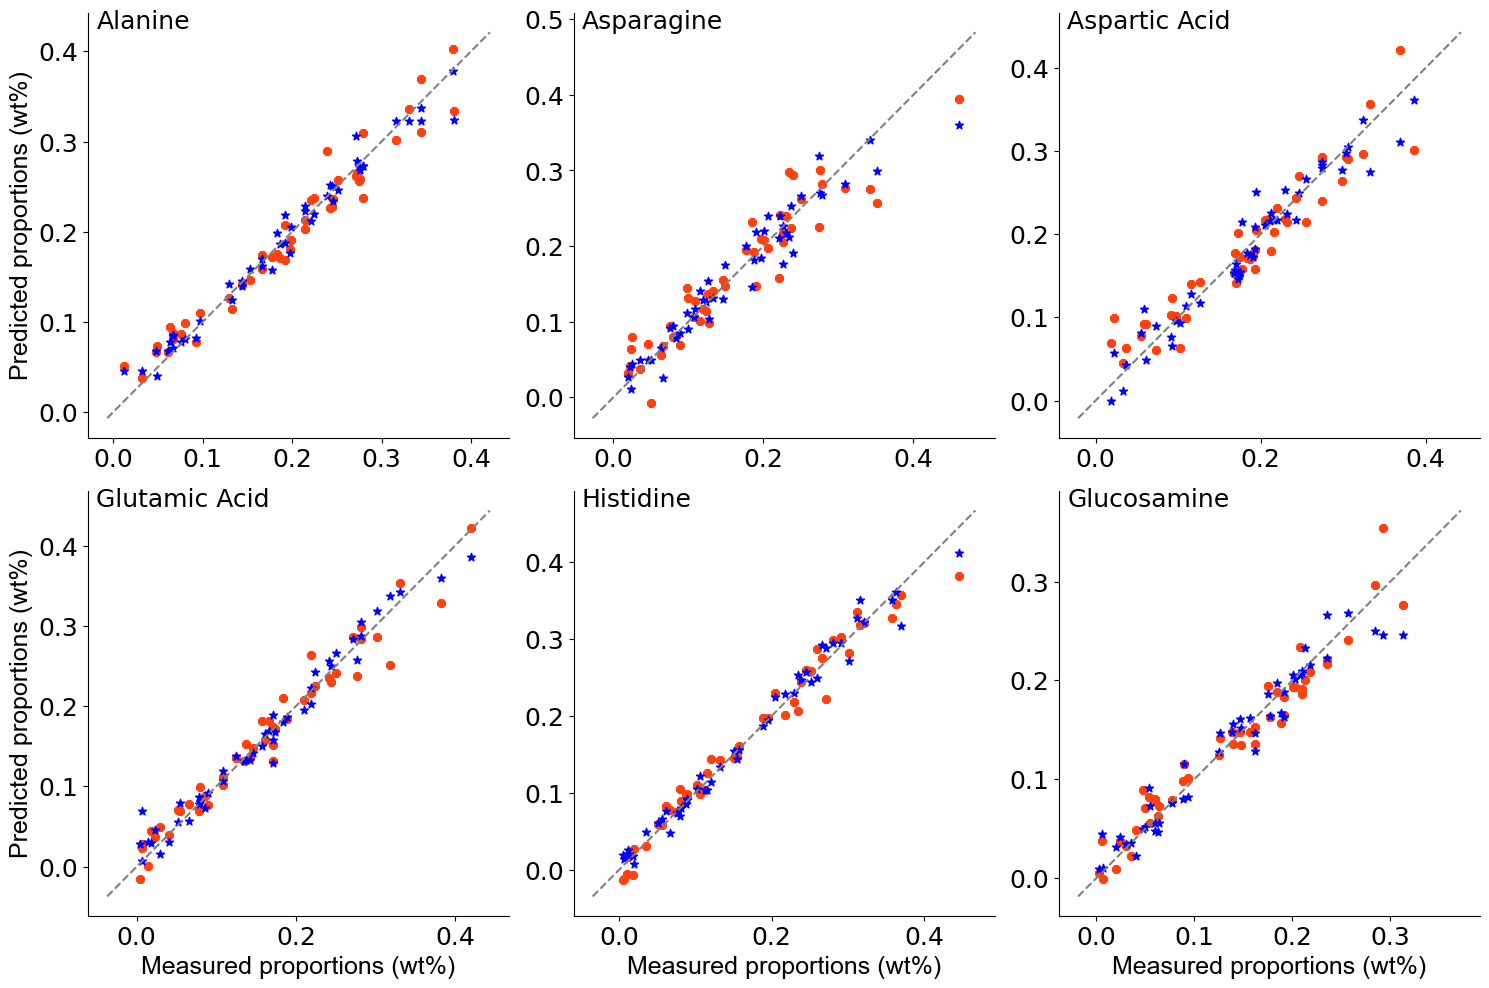

In [58]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import colorcet as cc
from matplotlib.ticker import StrMethodFormatter

saved_predictios_path = '/Users/mahsazarei/Grantlab Brugada Dropbox/Mahsa Zarei/A_Mahsa_Benchmarking_Data/manuscript_figures/saved_predictions_CSVs'
y_pred_cv_cnn_m4 = np.loadtxt(os.path.join(saved_predictios_path, 'y_pred_cv_cnn_m4.csv'), delimiter=',')
y_cv_cnn_m4 = np.loadtxt(os.path.join(saved_predictios_path, 'y_cv_cnn_m4.csv'), delimiter=',')

y_names = ['Alanine', 'Asparagine', 'Aspartic Acid', 'Glutamic Acid', 'Histidine', 'Glucosamine']
font = 'Arial'
axis_label_size = 18

# Create subplots
#the width is set to 3.25 inches, and the height is calculated to maintain the aspect ratio of 2:3
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10 ))


# Define the two colors for the scatter plots
colors = [cc.glasbey_dark[i] for i in [0, 5]]

# Loop over the targets of interest
for i, ax in enumerate(axs.flat):
    # Get the name of the target
    target_name = y_names[i]
    # Get the index of the target
    target_idx = i #idx[i]
    
    # Plot y_m4 vs y_pred_cv_plsr
    ax.scatter(y_ave[:, target_idx], y_pred_cv_plsr[:, target_idx], marker='8', c='#FE420F')
    # Plot y_m4 vs y_pred_cv_cnn
    ax.scatter(y_ave[:, target_idx], y_pred_cv_cnn_m4[:, target_idx], marker='*', c='blue')
    

    # Add the diagonal calibration line
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    minval = min(xmin, ymin)
    maxval = max(xmax, ymax)
    
    ax.plot([minval, maxval], [minval, maxval], ls='--', c='gray')
    
    # Set the axis labels
    ax.set_xlabel('Measured proportions (wt%)', fontsize=axis_label_size, fontname=font)
    ax.set_ylabel('Predicted proportions (wt%)', fontsize=axis_label_size, fontname=font)
    
    # Set the axis tick label font size
    ax.tick_params(axis='both', which='major', labelsize=axis_label_size)
    
    # Set the target name text inside the box in the top-left corner
    ax.text(0.02, 0.98, target_name, verticalalignment='center', horizontalalignment='left',
            transform=ax.transAxes, fontsize=axis_label_size, weight='book', color='black')#, bbox=dict(facecolor='white', edgecolor='black'))

for i, ax in enumerate(axs.flat):
    row = i // axs.shape[1]  # Calculate the row index
    col = i % axs.shape[1]   # Calculate the column index
    
    if col != 0:  # check if it's not the first column
        ax.set_ylabel('')  # remove the y-axis label for inner plots
    else:
        ax.set_ylabel('Predicted proportions (wt%)', fontsize=axis_label_size, fontname=font)
    
    if row != axs.shape[0] - 1:  # check if it's not the last row
        ax.set_xlabel('')  # remove the x-axis label for inner plots
        
    if row == axs.shape[0] - 1:  # check if it's the last row
        if i == axs.size - 1:  # check if it's the last subplot
            y_ticks = ax.get_yticks()  # Get the existing y-axis tick values
            y_ticks = [tick for tick in y_ticks if tick % 0.2 != 0.15 and tick % 0.2 != 0.25]  # Filter out specific values
            ax.set_yticks(y_ticks[1:-1])  # Set the filtered y-axis tick values

for ax in axs.flat:
    ax.spines['right'].set_visible(False)  # Remove right border
    ax.spines['top'].set_visible(False)    # Remove top border

# Adjust the space between the subplots
plt.tight_layout()

# fig.savefig('/Users/mahsazarei/Grantlab Brugada Dropbox/Mahsa Zarei/A_Mahsa_Benchmarking_Data/manuscript_figures/Figure3.pdf'\
#             , dpi=800)
